1. 평가 데이터 읽기
2. 평가 데이터 EDA
3. 평가 모델 가공
4. 저지 모델 추가
5. 평가
6. 평가 결과 가공
7. 평가 결과 EDA
8. 평가 결과 시각화


### import

In [77]:

from pathlib import Path
import pandas as pd
import numpy as np
from utils.logger import logger
from functools import reduce
from ast import literal_eval


import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import json
import re
import uuid










## 1. 데이터 가공

### 파일읽기

In [18]:
from pathlib import Path

current_dir = os.path.dirname(os.path.abspath(''))

current_dir

'/Users/dwkim7_pro/Dev/LLM_Judge'

In [ ]:
df_ans = pd.read_csv(f"{current_dir}/dataset/2.answer_data/702-samples-answered-by-midm-base-inst-2.3.2.csv")


df_ans = pd.read_csv(f"{current_dir}/dataset/2.answer_data/702-samples-answered-by-midm-base-inst-2.3.2.csv")
df_ans.head(3)

df_eval = pd.read_csv(f"{current_dir}/dataset/3.eval_data/702-samples-eval_midm-base-inst-2.3.2.csv")
df_eval.head(3)

#df_eval_result = pd.read_csv(f"{current_dir}/dataset/4.eval_result_data/702-samples-eval_feedback_midm-base-inst-2.3.2.csv")

#df_eval_result.head(3)


,no,domain,task,level,model,token_usage,prompt,response
0,1,D7,T9,L1,midm-base-inst,578,라인하르트 자프티히는 독일의 축구 감독이야.,"네, 라인하르트 자프티히(Rainer Zobel)는 독일 출신의 축구 감독입니다. ..."
1,2,D8,T6,L1,midm-base-inst,639,"""신세계는 어떤 영화인가요?""","""신세계""는 2013년에 개봉한 한국 범죄 스릴러 영화입니다. 박훈정 감독이 연출했..."
2,3,D3,T9,L1,midm-base-inst,588,다음 객관식 문제에 대한 올바른 옵션을 선택하세요.\n폴란드의 수도는 어디인가요?\...,폴란드의 수도는 C. 바르샤바입니다. \n\n바르샤바(Warsaw)는 폴란드의 수도...


In [ ]:

# csv 파일 합치기
df_eval_result1 = pd.read_csv(f"{current_dir}/dataset/4.eval_result_data/702-samples-eval_feedback_midm-base-inst-2.3.2.csv")
df_eval_result2 = pd.read_csv(f"{current_dir}/dataset/4.eval_result_data/702-samples-eval_feedback_midm-mini-inst-2.3.1.csv")
df_eval_result3 = pd.read_csv(f"{current_dir}/dataset/4.eval_result_data/702-samples-eval_feedback_midm-pro-inst-2.3.csv")
df_eval_result4 = pd.read_csv(f"{current_dir}/dataset/4.eval_result_data/702-samples-eval_feedback_llama-3-1-74b.csv")

#uuid = uuid.uuid4()



df_eval_all_result = pd.concat([df_eval_result1, df_eval_result2, df_eval_result3, df_eval_result4])


df_eval_all_result.head(3)



Index(['uuid', 'no', 'domain', 'task', 'level', 'model', 'token_usage',
       'prompt', 'response', 'midm-base-inst_result', 'midm-mini-inst_result',
       'midm-pro-inst_result', 'llama3.1-kt-chat-74b-3.0-fp8_result'],
      dtype='object')

In [ ]:


#df_eval_all_result 맨 앞열에 uniqueuuid 추가
#df_eval_all_result.insert(0, 'uuid', uuid)
#df_eval_all_result['uuid'] = [str(uuid.uuid4()) for _ in range(len(df_eval_all_result))]

df_eval_all_result.insert(0, 'uuid', [str(uuid.uuid4()) for _ in range(len(df_eval_all_result))])

df_eval_all_result.columns


Index(['uuid', 'no', 'domain', 'task', 'level', 'model', 'token_usage',
       'prompt', 'response', 'midm-base-inst_result', 'midm-mini-inst_result',
       'midm-pro-inst_result', 'llama3.1-kt-chat-74b-3.0-fp8_result'],
      dtype='object')

In [80]:

df_eval_all_result.head(3)
df_eval_all_result.uuid.value_counts()

uuid
8c6029b5-f89b-43c3-8a79-b65fb4a553bd    1
7e6e168f-d094-4206-9c72-e73bda9e4c1a    1
a91dfd7a-e8ce-4d57-8da0-01cd35529137    1
337e5e41-a4bb-4cbc-b486-2e0b76f85f7d    1
07f6a5fc-6773-4ab5-86e8-b0a1f482eb64    1
                                       ..
62cb5b3a-cf95-4499-9599-b8508ac0a499    1
a25ef262-3f55-4423-bcf4-81c0f0bb663b    1
060b8816-499d-4c2a-803e-7a2404458261    1
8c638d90-1533-4e1a-918d-5a63d423ed10    1
c3d1ba06-dd14-4b16-818a-6216eef78a08    1
Name: count, Length: 4000, dtype: int64

In [ ]:


#df_eval_all_result uuid 컬럼 삭제

df_eval_all_result = df_eval_all_result.drop('uuid', axis=1, errors='ignore')
print("uuid 컬럼 삭제 완료")

df_eval_all_result.columns


uuid 컬럼 삭제 완료


Index(['no', 'domain', 'task', 'level', 'model', 'token_usage', 'prompt',
       'response', 'midm-base-inst_result', 'midm-mini-inst_result',
       'midm-pro-inst_result', 'llama3.1-kt-chat-74b-3.0-fp8_result'],
      dtype='object')

In [ ]:

#csv 파일 저장
df_eval_all_result.to_csv(f"{current_dir}/dataset/4.eval_result_data/702-samples-eval_feedback_all.csv", index=False)

# df_eval_all_result.model.value_counts().plot(kind='bar')
# plt.show()

# df_eval_all_result.model.value_counts().plot(kind='pie')
# plt.show()

In [ ]:
df_eval_all_result.uuid.value_counts()

uuid
38ace959-3c42-4c4e-81dc-206f2efb6215    4000
Name: count, dtype: int64

In [ ]:
with open("../dataset/5.matrix_data/702-samples-eval_result_all.json", "r") as f:
    df_matrix = json.load(f)
print(df_matrix)

df_matrix1 = pd.DataFrame(df_matrix)

print(df_matrix1.head(3))
print(json.dumps(df_matrix, indent=4))
df_matrix = pd.DataFrame(df_matrix)
df_matrix.head(3)

#df_midm_mini = df_matrix[df_matrix['model'] == 'midm-mini-inst']
#df_midm_mini.head(3)

[{'no': 1, 'domain': 'D7', 'task': 'T9', 'level': 'L1', 'model': 'midm-mini-inst', 'token': 537, 'score': 1.5}, {'no': 2, 'domain': 'D8', 'task': 'T6', 'level': 'L1', 'model': 'midm-mini-inst', 'token': 651, 'score': 3.05}, {'no': 3, 'domain': 'D5', 'task': 'T9', 'level': 'L1', 'model': 'midm-mini-inst', 'token': 551, 'score': 5.3}, {'no': 4, 'domain': 'D8', 'task': 'T9', 'level': 'L1', 'model': 'midm-mini-inst', 'token': 548, 'score': 1.0}, {'no': 5, 'domain': 'D7', 'task': 'T9', 'level': 'L3', 'model': 'midm-mini-inst', 'token': 569, 'score': 1.3}, {'no': 6, 'domain': 'D8', 'task': 'T9', 'level': 'L1', 'model': 'midm-mini-inst', 'token': 528, 'score': 2.2}, {'no': 7, 'domain': 'D5', 'task': 'T8', 'level': 'L1', 'model': 'midm-mini-inst', 'token': 550, 'score': 3.55}, {'no': 8, 'domain': 'D8', 'task': 'T9', 'level': 'L1', 'model': 'midm-mini-inst', 'token': 553, 'score': 0.0}, {'no': 9, 'domain': 'D8', 'task': 'T9', 'level': 'L1', 'model': 'midm-mini-inst', 'token': 586, 'score': 3.0}

,no,domain,task,level,model,token,score
0,1,D7,T9,L1,midm-mini-inst,537,1.50
1,2,D8,T6,L1,midm-mini-inst,651,3.05
2,3,D5,T9,L1,midm-mini-inst,551,5.30


### 디렉토리 파일 읽기(확인)

In [ ]:
list_root_dir = Path('dataset/3.eval_data')
dict_llm2df = {}
i = 0
y = 0 

## 확인필요
for dir in list_root_dir.iterdir():
    i += 1  
    #print(dir.name.split('eval_')[1])
    for file in dir.glob('*.csv'):
        y += 1
        if file.is_file():
            print(file.name)
            dict_llm2df[dir.name.split('eval_')[1].split('.')[0]] = pd.read_csv(file)
print(i)
print(y)
list(sorted(dict_llm2df.keys()))

In [86]:
list_root_dir = Path('../dataset/3.eval_data')
dict_llm2df = {}

for file in list_root_dir.glob('702*.csv'):
    print(file)
    model = file.stem.split('eval_')[1].split('.csv')[0]
    dict_llm2df[model] = pd.read_csv(file)
    print(model, " : ", len(dict_llm2df[model]))
    print("--------------------------------")
    
list(sorted(dict_llm2df.keys()))

dict_llm2df['midm-mini-inst-2.3.1'].head(3)
#dict_llm2df

../dataset/3.eval_data/702-samples-eval_midm-pro-inst-2.3.csv
midm-pro-inst-2.3  :  1000
--------------------------------
../dataset/3.eval_data/702-samples-eval_midm-mini-inst-2.3.1.csv
midm-mini-inst-2.3.1  :  1000
--------------------------------
../dataset/3.eval_data/702-samples-eval_midm-base-inst-2.3.2.csv
midm-base-inst-2.3.2  :  1000
--------------------------------
../dataset/3.eval_data/702-samples-eval_llama-3-1-74b.csv
llama-3-1-74b  :  1000
--------------------------------
../dataset/3.eval_data/702-samples-eval_gpt-4o.csv
gpt-4o  :  1000
--------------------------------


,no,domain,task,level,model,token_usage,prompt,response
0,1,D7,T9,L1,midm-mini-inst,537,라인하르트 자프티히는 독일의 축구 감독이야.,"네, 맞습니다. 라인하르트 자프티히는 독일의 축구 감독으로 활동한 인물입니다."
1,2,D8,T6,L1,midm-mini-inst,651,"""신세계는 어떤 영화인가요?""","""신세계""는 2013년에 개봉한 한국 영화로, 범죄와 조직폭력을 소재로 한 작품입니..."
2,3,D5,T9,L1,midm-mini-inst,551,다음 객관식 문제에 대한 올바른 옵션을 선택하세요.\n폴란드의 수도는 어디인가요?\...,폴란드의 수도는 C. 바르샤바입니다.


### 데이터 클렌징

In [384]:
df_matrix.head(3)


df_matrix['domain'].value_counts()

df_matrix['domain'].count()

df_matrix['domain'].unique()


for domain in df_matrix['domain']:
     #print(domain)
     #만약 도메인에 "\n\n"이 있으면 제거
     if "\n\n" in domain:
         #print(domain)
         domain = domain.split('\n\n')[0]
         #print(domain)
         #print("--------------------------------")
         

print(df_matrix['score'].unique())
df_matrix['score'].value_counts()





[1.5   3.05  5.3   1.    1.3   2.2   3.55  0.    3.    2.6   0.5   4.6
 4.3   4.75  5.2   4.5   4.8   0.9   2.5   4.9   3.9   4.175 4.05  3.2
 3.1   1.95  1.7   0.55  4.35  4.025 4.375 2.    4.65  2.9   4.7   3.4
 2.999 0.8   2.7   1.35  4.06  3.8   3.6   1.2   1.1   4.61  2.8   4.4
 4.45  4.575 4.315 3.65  4.82  5.05  4.55  3.95  4.2   4.    4.1   2.1
 2.75  4.027 3.5   4.49  1.9   4.135 4.655 3.03  4.85  5.    3.75  4.93
 3.35  3.3   4.525 4.63  2.55  3.04  4.59  1.6   3.7   3.735 2.05  4.48
 2.4   3.45  4.94  4.71  4.305 0.75  3.82  4.27  4.325 4.365 4.355 2.3
 1.4   4.285 4.26  5.1   3.69  4.44  4.225 4.595 3.995 4.25  5.04  1.8
 3.15  4.625 1.55  4.215 4.73  4.775 0.1   1.65  4.36  4.275 4.404 3.46
 0.7   1.15  4.58  4.825 3.25  3.728 4.385 2.333 4.617 4.633 4.635 5.15
 3.67  2.15  3.945 2.95  2.425 5.225 3.79  4.29  4.69  4.845 5.5   4.15
 4.34  0.4   4.39  4.265 4.415 3.767 4.16  4.475 4.204 4.41  0.2   4.665
 4.925 4.74  4.37  4.045 3.275 4.675 4.075 4.335 4.388 4.33  4.68  4.8

score
5.300    1527
4.700     206
4.750     159
4.300     112
4.800     104
         ... 
4.845       1
3.790       1
5.225       1
2.425       1
4.085       1
Name: count, Length: 254, dtype: int64

#### domain, task, level 데이터 분포 확인

##### domain, task, level 데이터 클렌징

In [ ]:
# domain, task, level 데이터 분포 확인

#df_matrix['domain'].value_counts()
#df_matrix['task'].value_counts()
#df_matrix['level'].value_counts()

#df_matrix['domain'].unique()
#df_matrix['task'].unique()
#df_matrix['level'].unique()

#데이터 클렌징
#df_matrix['domain'] = df_matrix['domain'].str.split('\n\n').str[0]

#domain D1, D2, D3, D4, D5, D6, D7, D8, D9, D10 외에 데이터 제거
#df_matrix = df_matrix[df_matrix['domain'].isin(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'])]
#df_matrix['domain'].unique()

#domain D1, D2, D3, D4, D5, D6, D7, D8, D9, D10 이 포함된 데이터만 남기기
#df_matrix = df_matrix[df_matrix['domain'].str.contains('D1|D2|D3|D4|D5|D6|D7|D8|D9|D10')]

# df_matrix['task'].value_counts()
# print(len(df_matrix['task']))
# df_matrix['task'] = df_matrix['task'].str.split('\n\n').str[0]
# df_matrix = df_matrix[df_matrix['task'].str.contains('T1|T2|T3|T4|T5|T6|T7|T8|T9|T10|T11|T12')]
# print(len(df_matrix['task']))
# df_matrix['task'].value_counts()

# df_matrix['level'].value_counts()
# print(len(df_matrix['level']))
# df_matrix['level'] = df_matrix['level'].str.split('\n\n').str[0]
# df_matrix = df_matrix[df_matrix['level'].str.contains('L1|L2|L3')]
# print(len(df_matrix['level']))
# df_matrix['level'].value_counts()

df_matrix['domain'].value_counts()
df_matrix['task'].value_counts()
df_matrix['level'].value_counts()



 







domain
D8     906
D2     597
D5     562
D3     558
D4     250
D7     236
D9     236
D6     236
D1     217
D10     30
Name: count, dtype: int64

#### score 분포 확인

[Text(0, 0, '0-0.5'),
 Text(1, 0, '1-1.5'),
 Text(2, 0, '2-2.5'),
 Text(3, 0, '3-3.5'),
 Text(4, 0, '4-4.5'),
 Text(5, 0, '5-5.5')]

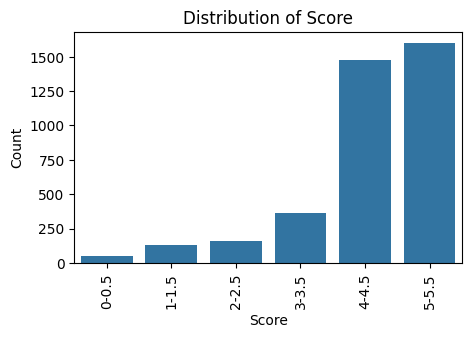

In [359]:
# 데이터 분포 확인
# df_matrix['score'].head(3)
# df_matrix['score'].value_counts()
# df_matrix['score'].unique()

# 바차트 생성
# 점수 범위는 0~6점까지 0.5점 단위로 계산
# x축 라벨은 점수 범위로 표시
# y축 라벨은 점수 범위에 해당하는 데이터의 개수로 표시
# 차트의 제목은 'Distribution of Score'로 표시
# 차트의 x축 라벨은 'Score'로 표시
# 차트의 y축 라벨은 'Count'로 표시

df_matrix['score_range'] = pd.cut(df_matrix['score'], bins=range(0, 7, 1), labels=[f'{i}-{i+0.5}' for i in range(0, 6, 1)])
df_matrix['score_range'].unique()

# 점수 범위별 데이터 개수 계산
score_counts = df_matrix['score_range'].value_counts().sort_index()

# 바차트 생성
bar_chart = sns.barplot(x=score_counts.index, y=score_counts.values)
bar_chart.figure.set_size_inches(5, 3)
bar_chart.set_title('Distribution of Score')
bar_chart.set_xlabel('Score')
bar_chart.set_ylabel('Count')
bar_chart.set_xticks(bar_chart.get_xticks())
bar_chart.set_xticklabels(bar_chart.get_xticklabels(), rotation=90)


### 캐쉬 활용

In [ ]:
zzz

### response 데이터 가공

In [89]:
# 2.answer_data 파일 읽기
df_ans = pd.read_csv(f"{current_dir}/dataset/2.answer_data/702-samples-answered-by-midm-base-inst-2.3.2.csv")
df_ans.head(3)


list_root_dir = Path('../dataset/2.answer_data')
response_dict = {}

for file in list_root_dir.glob('702*.csv'):
    print(file)
    model = file.stem.split('by-')[1].split('.csv')[0]
    file_name = file.name
    
    response_dict[model] = pd.read_csv(file)
    print(model, " : ", len(response_dict[model]))
    print("--------------------------------")
    
list(sorted(dict_llm2df.keys()))

../dataset/2.answer_data/702-samples-answered-by-gpt-4o.csv
gpt-4o  :  1000
--------------------------------
../dataset/2.answer_data/702-samples-answered-by-midm-pro-inst-2.3.csv
midm-pro-inst-2.3  :  1000
--------------------------------
../dataset/2.answer_data/702-samples-answered-by-llama-3-1-74b.csv
llama-3-1-74b  :  1000
--------------------------------
../dataset/2.answer_data/702-samples-answered-by-midm-mini-inst-2.3.1.csv
midm-mini-inst-2.3.1  :  1000
--------------------------------
../dataset/2.answer_data/702-samples-answered-by-midm-base-inst-2.3.2.csv
midm-base-inst-2.3.2  :  1000
--------------------------------


['gpt-4o',
 'llama-3-1-74b',
 'midm-base-inst-2.3.2',
 'midm-mini-inst-2.3.1',
 'midm-pro-inst-2.3']

## 2. 데이터 탐색

### EDA 데이터 탐색

In [190]:
result_file = 'dataset/4.eval_result_data/702-samples-eval_feedback_midm-mini-inst-2.3.1.csv'
df = pd.read_csv(result_file)

# df.info()
# df.describe()
# df['domain'].value_counts()
# df['prompt'].to_dict()
df.head(3)
#dict_llm2df['midm-mini-inst-2.3.1'].head(3)

,no,domain,task,level,model,token_usage,prompt,response,midm-mini-inst_result
0,1,D7,T9,L1,midm-mini-inst,537,라인하르트 자프티히는 독일의 축구 감독이야.,"네, 맞습니다. 라인하르트 자프티히는 독일의 축구 감독으로 활동한 인물입니다.","```json\n{\n ""Accuracy"": 0.000,\n ""Consisten..."
1,2,D8,T6,L1,midm-mini-inst,651,"""신세계는 어떤 영화인가요?""","""신세계""는 2013년에 개봉한 한국 영화로, 범죄와 조직폭력을 소재로 한 작품입니...","```json\n{\n ""Accuracy"": 0.500,\n ""Consisten..."
2,3,D5,T9,L1,midm-mini-inst,551,다음 객관식 문제에 대한 올바른 옵션을 선택하세요.\n폴란드의 수도는 어디인가요?\...,폴란드의 수도는 C. 바르샤바입니다.,"```json\n{\n ""Accuracy"": 1.5,\n ""Consistency..."


In [191]:

df_midm_mini = dict_llm2df_input_data['midm-mini-inst-2.3.1']
df_midm_mini.head(5)

# df_midm_mini.info()
# df_midm_mini.describe()
# df_midm_mini['domain'].value_counts()
# df_midm_mini['prompt'].to_dict()
# df_midm_mini.head(3)

,no,domain,task,level,model,token_usage,prompt,response,midm-mini-inst_result
0,1,D7,T9,L1,midm-mini-inst,537,라인하르트 자프티히는 독일의 축구 감독이야.,"네, 맞습니다. 라인하르트 자프티히는 독일의 축구 감독으로 활동한 인물입니다.","```json\n{\n ""Accuracy"": 0.000,\n ""Consisten..."
1,2,D8,T6,L1,midm-mini-inst,651,"""신세계는 어떤 영화인가요?""","""신세계""는 2013년에 개봉한 한국 영화로, 범죄와 조직폭력을 소재로 한 작품입니...","```json\n{\n ""Accuracy"": 0.500,\n ""Consisten..."
2,3,D5,T9,L1,midm-mini-inst,551,다음 객관식 문제에 대한 올바른 옵션을 선택하세요.\n폴란드의 수도는 어디인가요?\...,폴란드의 수도는 C. 바르샤바입니다.,"```json\n{\n ""Accuracy"": 1.5,\n ""Consistency..."
3,4,D8,T9,L1,midm-mini-inst,548,비앙카 모블리의 출신 국적은 어디인가?,"비앙카 모블리는 미국 국적을 가진 인물입니다. 그녀는 미국의 배우, 가수, 댄서, ...","```json\n{\n ""Accuracy"": 0.0,\n ""Consistency..."
4,5,D7,T9,L3,midm-mini-inst,569,한명련은 무엇을 했나?,"한명련은 대한민국의 정치인으로, 더불어민주당 소속의 국회의원입니다. 그는 2018년...","```json\n{\n ""Accuracy"": 0.200,\n ""Consisten..."


In [295]:
df_midm_mini.head(3)

df_midm_mini['level'].value_counts()
df_matrix['domain'].value_counts()


domain
D8                                                       907
D2                                                       564
D5                                                       562
D3                                                       551
D4                                                       249
                                                        ... 
D2\n\n이 질문은 일본의 경제 정책, 통화 가치 조정, 국제 기구와의 협력                1
D2\n\n주식과 채권을 사용한 복제 포트폴리오 구성과 관련된 질문은 금융공학, 포트폴리오 이론      1
D2\n\n이 질문은 금융 파생상품인 ATM 스왑션(ATM Swaption)의 차익             1
D3\n\n이 질문은 확률론과 금융수학에서 사용되는 위험 척도(risk measure)에          1
D4,D9                                                      1
Name: count, Length: 91, dtype: int64

In [193]:
list_task_label = [f"T{i}" for i in range(1, 13)]
list_domain_label = [f"D{i}" for i in range(1, 11)]
list_level_label = [f"L{i}" for i in range(1, 4)]
list_task_label, list_domain_label, list_level_label

(['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12'],
 ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'],
 ['L1', 'L2', 'L3'])

In [194]:
list_labels = []
for t in list_task_label:
    for d in list_domain_label:
        for l in list_level_label:
            list_labels.append({
                "T": t,
                "D": d,
                "L": l,
            })
df_tld = pd.DataFrame(list_labels)
df_tld['count'] = 0.0
df_tld

,T,D,L,count
0,T1,D1,L1,0.0
1,T1,D1,L2,0.0
2,T1,D1,L3,0.0
3,T1,D2,L1,0.0
4,T1,D2,L2,0.0
...,...,...,...,...
355,T12,D9,L2,0.0
356,T12,D9,L3,0.0
357,T12,D10,L1,0.0
358,T12,D10,L2,0.0


In [285]:
df_midm_mini.head(3)


,no,domain,task,level,model,token,score
0,1,D7,T9,L1,midm-mini-inst,537,1.50
1,2,D8,T6,L1,midm-mini-inst,651,3.05
2,3,D5,T9,L1,midm-mini-inst,551,5.30


In [196]:
i = 0
y=0 
for index, row in tqdm(df_midm_mini.iterrows()):
    y+=1
    T = row['task']
    D = row['domain']
    L = row['level']

    increamental_count = 1 / (len(T) * len(D) * len(L))
    Tn = T.count(",") + 1
    Dn = D.count(",") + 1
    Ln = L.count(",") + 1
    
    increamental_count = 1 / (Tn * Dn * Ln)
    if Tn > 1 or Dn > 1 or Ln > 1:
        print(T, D, L)
        print(Tn, Dn, Ln)
        print(increamental_count)
        print("--------------------------------")
        continue
    for t_to_count, d_to_count, l_to_count in itertools.product(T, D, L):
        i += 1
        mask = (
            (df_tld['T'] == t_to_count) &
            (df_tld['D'] == d_to_count) &
            (df_tld['L'] == l_to_count)
        )
        df_tld.loc[mask, 'count'] += increamental_count

print(df_tld['count'].value_counts())
print(i)
print(y)

134it [00:00, 445.32it/s]

T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T3 D3,D5 L3
1 2 1
0.5
--------------------------------
T3,T8 D5 L3
2 1 1
0.5
--------------------------------


270it [00:00, 445.06it/s]

T8 D3,D5 L3
1 2 1
0.5
--------------------------------
T8 D3,D5 L3
1 2 1
0.5
--------------------------------
T3 D3,D2 L3
1 2 1
0.5
--------------------------------
T3,T8 D2,D5 L3
2 2 1
0.25
--------------------------------


458it [00:01, 462.39it/s]

T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T3,T8 D2 L3
2 1 1
0.5
--------------------------------
T3 D3,D5 L3
1 2 1
0.5
--------------------------------
T3,T8 D3,D2,D5 L3
2 3 1
0.16666666666666666
--------------------------------
T3,T8 D2 L3
2 1 1
0.5
--------------------------------


559it [00:01, 481.87it/s]

T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D5,D2,D3 L3
1 3 1
0.3333333333333333
--------------------------------
T8 D3,D5 L3
1 2 1
0.5
--------------------------------


756it [00:01, 463.18it/s]

T8 D3,D5 L3
1 2 1
0.5
--------------------------------
T3,T8 D2,D5 L3
2 2 1
0.25
--------------------------------
T3,T8 D2,D3 L3
2 2 1
0.25
--------------------------------
T3 D2,D5 L3
1 2 1
0.5
--------------------------------
T3,T8 D3,D5 L3
2 2 1
0.25
--------------------------------
T3,T8 D2 L3
2 1 1
0.5
--------------------------------
T3,T8 D5 L3
2 1 1
0.5
--------------------------------
T3,T8 D2 L3
2 1 1
0.5
--------------------------------


851it [00:01, 463.78it/s]

T8 D3,D5 L3
1 2 1
0.5
--------------------------------
T8 D3,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D3,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T8 D2,D5 L3
1 2 1
0.5
--------------------------------


1000it [00:02, 454.39it/s]

T8 D2,D5 L3
1 2 1
0.5
--------------------------------
T9 D3,D4 L2
1 2 1
0.5
--------------------------------
T8 D2,D3 L3
1 2 1
0.5
--------------------------------
count
0.0    360
Name: count, dtype: int64
7838
1000


### TLDC 별 데이터 분포 



In [385]:
#df_heat = df_matrix.pivot_table(index=['task', 'level'], columns='domain', values='count')
#df = df_matrix.groupby(['task', 'level', 'domain']).size().reset_index(name='count')
#df.head(13)


# fig = plt.figure(figsize=(8,8))
# fig.set_facecolor('white')

df_matrix = pd.crosstab(
    index = df_matrix['domain'],
    columns = df_matrix['task']
)

df_matrix.head(3)

# heat_domain = sns.heatmap(
#      data = df_matrix.corr(numeric_only=True),
#      annot=True,
#      cmap='coolwarm',
#      vmin=-1,
#      vmax=1,
#      center=0,
#      square=True,
#      linewidths=0.5,
# )

# x축 위에 표시
# heat_domain.xaxis.tick_top()

# 차트 크기 조정
# fig, ax = plt.subplots(1, 1, figsize=(8,5)) #그래프 크기 조정


# 히트맵 이미지 저장
# heat_domain.figure.savefig("heat_domain.png")
 
plt.show()

In [293]:
df_matrix['domain'].value_counts()

domain
D8                                                       907
D2                                                       564
D5                                                       562
D3                                                       551
D4                                                       249
                                                        ... 
D2\n\n이 질문은 일본의 경제 정책, 통화 가치 조정, 국제 기구와의 협력                1
D2\n\n주식과 채권을 사용한 복제 포트폴리오 구성과 관련된 질문은 금융공학, 포트폴리오 이론      1
D2\n\n이 질문은 금융 파생상품인 ATM 스왑션(ATM Swaption)의 차익             1
D3\n\n이 질문은 확률론과 금융수학에서 사용되는 위험 척도(risk measure)에          1
D4,D9                                                      1
Name: count, Length: 91, dtype: int64

In [ ]:


x = [f"{task_label}" for task_label in df_matrix]
y = [df_tld.groupby('task')['count'].sum()[task_label] for task_label in df_matrix]

plt.figure(figsize=(5, 3))
plt.bar(x, y, color='skyblue')
plt.title('Bar Chart of # of Task Labels')
plt.xlabel('Task')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

KeyError: 'task'

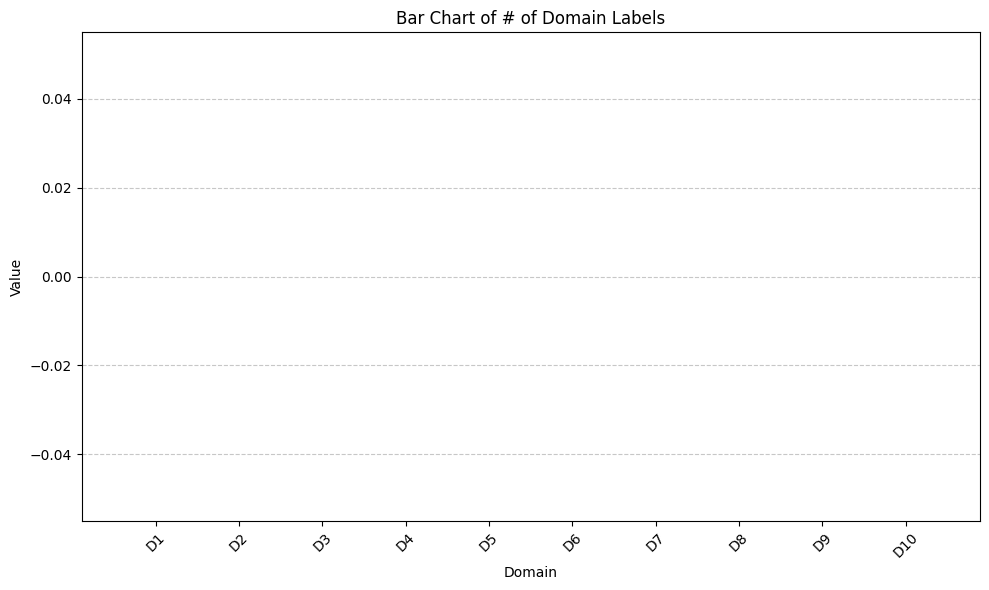

In [268]:
x = [f"{domain_label}" for domain_label in list_domain_label]
y = [df_tld.groupby('D')['count'].sum()[domain_label] for domain_label in list_domain_label]

plt.figure(figsize=(10, 6))
plt.bar(x, y, color='orange')
plt.title('Bar Chart of # of Domain Labels')
plt.xlabel('Domain')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### TLDC별 합산스코어 분포


### 평가기준별 데이터분포
#### 평가기준별 스코어분포



## 3. LLM 품질 Matrics

### 최종 모델별 품질 Matrics
#### 품질
#### 비용
#### 최적화(KORA)

In [186]:
pivot_df = df_tld.pivot_table(index=['T','L'], columns=['D'], values='count', fill_value=0)

print(pivot_df)

D        D1  D10   D2   D3   D4   D5   D6   D7   D8   D9
T   L                                                   
T1  L1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
T10 L1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
T11 L1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
T12 L1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
T2  L1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    L3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
T3  L1  0.0  0.0  0.0  0.0  0.0

In [187]:
df_tld['count'] = df_tld['count'].map(lambda x: 0 if x < 1 else int(x))

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/var/folders/6d/l826_sjd2cj56sdctgdqv8zw0000gn/T/ipykernel_50885/410446060.py:15: SyntaxWarning: invalid escape sequence '\d'
  return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]


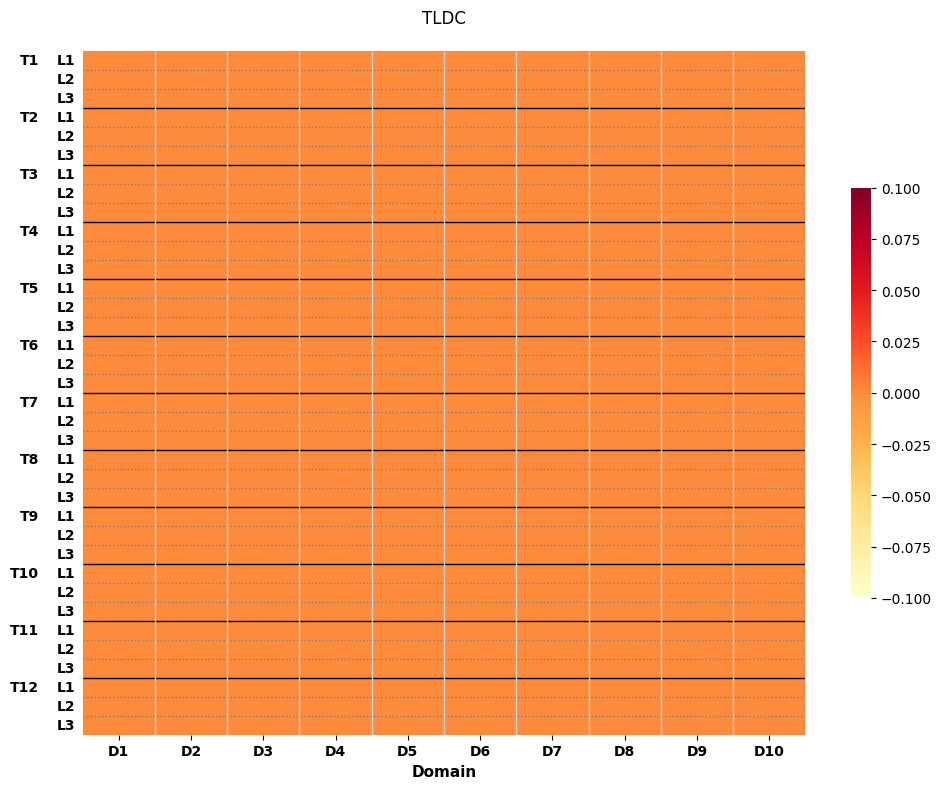

In [188]:
from matplotlib.colors import LinearSegmentedColormap

# 0은 흰색, 그 이후는 YlOrRd 그대로 쓰기
orig_cmap = sns.color_palette("YlOrRd", as_cmap=True)
colors = [(1, 1, 1)] + [orig_cmap(i) for i in np.linspace(0, 1, 255)[1:]]  # 첫 색만 흰색으로
custom_cmap = LinearSegmentedColormap.from_list("custom_YlOrRd", colors, N=256)

# NaN용 색 설정
custom_cmap.set_bad("lightgray")



# 자연 정렬 함수
def natural_key(text):
    return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]

# pivot (fill_value 제거!)
pivot_df = df_tld.pivot_table(index=['T', 'L'], columns='D', values='count')  # NaN 남김

# 정렬
t_vals = [t for t, l in pivot_df.index]
sorted_idx = sorted(range(len(t_vals)), key=lambda i: natural_key(t_vals[i]))
sorted_columns = sorted(pivot_df.columns, key=lambda x: natural_key(x))
pivot_df_sorted = pivot_df.iloc[sorted_idx][sorted_columns]

# mask (NaN)
mask = pivot_df_sorted.isna()

# annot 생성: 0, NaN 은 공백
annot = pivot_df_sorted.copy()
annot = annot.fillna(0).astype(int).astype(str)
annot = annot.mask(pivot_df_sorted == 0, "")
annot = annot.mask(mask, "")

# T, L 분리
T_vals = [t for t, l in pivot_df_sorted.index]
L_vals = [l for t, l in pivot_df_sorted.index]

# 컬러맵: 0은 흰색, NaN은 회색
cmap = sns.color_palette("YlOrRd", as_cmap=True)
cmap.set_bad("lightgray")

# plot
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    pivot_df_sorted,
    annot=annot,
    fmt="",
    cmap=custom_cmap,
    mask=mask,
    cbar=True,
    yticklabels=False,
    cbar_kws={'shrink': 0.6},
    vmin=0
)

# T/L 레이블 수동 삽입
y_pos = np.arange(len(T_vals)) + 0.5
prev_t = None
for i, (t, l) in enumerate(zip(T_vals, L_vals)):
    t_text = t if t != prev_t else ""
    ax.text(-0.6, y_pos[i], t_text, va='center', ha='right', fontsize=10, fontweight='bold')
    ax.text(-0.1, y_pos[i], l, va='center', ha='right', fontsize=10, fontweight='bold')
    prev_t = t

# x축 레이블 bold
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# 구분선
t_change_idx = [i for i in range(1, len(T_vals)) if T_vals[i] != T_vals[i-1]]
l_change_idx = [i for i in range(1, len(L_vals)) if L_vals[i] != L_vals[i-1]]
for y in t_change_idx:
    ax.hlines(y, *ax.get_xlim(), colors='black', linewidth=1)
for y in l_change_idx:
    if y not in t_change_idx:
        ax.hlines(y, *ax.get_xlim(), colors='gray', linestyles='dotted', linewidth=1)

# x축 세로선
n_cols = len(pivot_df_sorted.columns)
for x in range(1, n_cols):
    ax.vlines(x, *ax.get_ylim(), colors='lightgray', linewidth=1)

# 라벨 및 타이틀
ax.set_ylabel("")
ax.set_xlabel("Domain", fontsize=11, fontweight='bold')
plt.title("TLDC", pad=20)
plt.tight_layout()
plt.show()

In [189]:
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

dataset_dir = os.path.join(os.path.dirname(__file__), '..', 'dataset')
result_files = [f for f in os.listdir(dataset_dir) if f.startswith('eval_results_') and f.endswith('.json')]

if not result_files:
    st.error('평가 결과 파일이 없습니다.')
    st.stop()

result_file = st.selectbox('결과 파일 선택', result_files)
RESULT_PATH = os.path.join(dataset_dir, result_file)

# 데이터 로드
with open(RESULT_PATH, encoding='utf-8') as f:
    results = json.load(f)

# D1~D12, T1~T11 정의
domains = [f'D{i}' for i in range(1, 11)]
tasks = [f'T{i}' for i in range(1, 12)]
levels = ['1', '2', '3']

# 모델 선택
model_names = sorted(list(set(r['model'] for r in results)))
model = st.selectbox("모델 선택", model_names)

NameError: name '__file__' is not defined